#WomboCombo: Optimizing Team Composition in League of Legends
### by Data of Legends (Sean Cha, Jaemin Cheun, Kenny Lei, Andrew Paek) 
###Assigned TF: Léandra King

<img src="http://36646d87786feafc0611-0338bbbce19fc98919c6293def4c5554.r0.cf1.rackcdn.com/images/FiGZ9r3D3E82.878x0.Z-Z96KYq.jpg" width=610 height=347/>

#Table of Contents

* [WomboCombo: Optimizing Team Composition in League of Legends](#WomboCombo: Optimizing Team Composition in League of Legends)
	* [Introduction](#Introduction)
		* [Different Roles](#Different Roles)
        * [Objectives](#Objectives)
	* [Part I: Data Retrieval & Cleaning](#Part-I-Data-Retrieval-&-Cleaning)
		* [League of Legends API](#LoL-API)
        * [Pulling and Saving JSON Files](#JSON-Files)
		* [Pre-processing Data](#pre-processing)
		* [Feature Selection](#feature-selection)
        * [Parsing JSON into a csv](#parsing)
    * [Part II: Exploratory Data Analysis (EDA)](#EDA)
		* [Rank Tier and Region Distribution](#tier-region-dist)
		* [Most Popular Champions](#popular_champ)
        * [Win/Loss Rate Based on Champion](#win_loss_rate)
        * [KDA by Champion](#KDA)
        * [Champions by Stat](#champion-stat)
    * [Part III: Clustering Algorithms](#clustering)
        * [Standardization](#standardization)
		* [Making baseline predictions](#Making-baseline-predictions)
			* [1.3 Make the prediction from the `baseline` model](#1.3-Make-the-prediction-from-the-baseline-model)        
    * [Part III: Clustering Algorithms](#clustering)
        * [Standardization](#standardization)
		* [Making baseline predictions](#Making-baseline-predictions)
			* [1.3 Make the prediction from the `baseline` model](#1.3-Make-the-prediction-from-the-baseline-model)        
       
      

##Introduction <a id='Introduction'></a>

League of Legends (LoL) is currently the most popular game in the world. LoL is a fast-paced, competitive online game that blends the speed and intensity of an RTS with RPG elements. Two teams of 5 powerful champions, each with a unique design and playstyle, battle head-to-head across multiple battlefields and game modes. With an ever-expanding roster of champions, frequent updates and a thriving tournament scene, League of Legends offers endless replayability for players of every skill level.

The main objective of the game is to knock down the enemies' towers using the champions, while the enemy team is trying to do the same to ours. Towers are difficult to destroy with the enemy defending them, so most of the game revolves around killing enemy champions in order to buy the necessary time to bring down enemy towers.

Team composition is extremely important in the game. Each champion out of the roster of 128 (and growing!) carries its own unique abilities, utility, and play style that it can contribute to the team. Simply put, a team of 5 champions that share similar roles in the game would be very ineffective against a well-balanced team. Let's look at some examples.

### Different Roles <a id='Different Roles'></a>
This is LeBlanc. Her primary role in the game is an assassin. She has an extremely low physical damage power (red bar) and low health (green bar). However, she has a HUGE ability power (blue bar), allowing her to use quick burst of ability power to kill enemies in a split second. She is extremely effective in assassinating enemy champions that are roaming around the map by themselves. Since her abilities have a very long cool-down (time for her to be able to cast spells again), she is in deep trouble if she cannot kill the enemy champion the first time around. In a team fight, LeBlanc focuses on killing high priority enemy champions. This is an old video from a few seasons back, but it really demonstrates what LeBlanc is capable of: https://www.youtube.com/watch?v=lsBJEvwi66k.
<img src=http://i.imgur.com/G5jbBpq.png>

This is Malphite. His primary role is a tank. He has high health and defensive statistics, allowing him to last a long time in a team fight. Although he cannot quickly kill enemy champions the way LeBlanc does, he is able to follow around and harrass/interrupt high-priority enemy champions in their attempts to kill ours. He is also an "utility" champion, meaning that he has various "crowd-controlling" abilities that slow down and knocks up enemy champions, making it easier for our champions to target them. This is an example of Malphite's specialty in initiating a team fight and tankiness: https://youtu.be/pE3aLnoB7oA?t=17m53s.
<img src=http://i.imgur.com/POWWt9u.png>

These are only 2 of the 128 champions that players can choose to play. As you can see, LeBlanc and Malphite have very distinctly different roles in the game. It would be a disaster for a team to have 5 "tank" champions, since tanky champions, despite their resilience, cannot deal enough damage to kill enemy champions. A team of only assassins will also have no luck in winning; without a reliable tanker to take the frontline and disrupt the enemy, the LeBlancs will quickly "evaporate to death."

This is where team composition comes in. A team that has both a Malphite and a LeBlanc will be extremely effective. While Malphite slows down enemies and takes all the damages, LeBlanc can focus on dealing massive magic damage to the enemy champions. Other notable roles include that of a fighter (a champion that can deal consistent damage over time while taking moderate damage), a support (a champion specializing in crowd control abilities to disable enemy champions and healing to protect our champions), a marksman (a range-attack champion who is extremely vulnerable but can deal a massive amount of damage from a distance), etc.

Certain set of champions complement each other really well, thus the coinage of the term, Wombo Combo. To look at some examples of Wombo Combos, please see: https://www.youtube.com/watch?v=TW6bdxnFcjs

There are six acknowledged roles for champions: Tank, Fighter, Assassin, Mage, Support, Marksmen. Each of these roles have different play styles, and corresponding champions, and different combinations of these roles may make for a strong or weak team, relative to the composition of the the team. Therefore, given the number of people playing each role on one team, and the number of players in each role on the opposing team, we may be able to roughly predict the outcome of a game. 

###Objectives <a id='Objectives'></a>

We hope to gain insight on optimal team composition by analyzing match data.

First, we use Riot's League of Legends API (https://developer.riotgames.com/docs/rate-limiting) to download the necessary data. Then, we preprocess and clean the raw JSON data to a workable structure.

Next, we conduct Exploratory Data Analysis (EDA) to answer some basic questions regarding our data set. By visualizing and playing around with the data, we gain additional insight that will be helpful in later parts.

Then, we ... (WRITE ABOUT ALGORITHMS HERE)

In [1]:
%matplotlib inline
import os
import json
import requests
import time
import datetime
import types
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


##Part I: Data Retrieval & Cleaning<a id='Part-I-Data-Retrieval-&-Cleaning'></a>

### League of Legends API <a id='LoL-API'></a>

Rate Limiting: The API allows one user to make 10 requests per 10 seconds and 500 requests per 10 minutes.

For documentation, see https://developer.riotgames.com/api/methods.

From the riot games API page,  
<b>"The rate limit for development keys is by design very limited:   
10 requests every 10 seconds  
                                                                500 requests every 10 minutes" </b>

However,

<b>"Note that rate limits are enforced per region. For example, with the above rate limit, you could make 10 requests every 10 seconds to both NA and EUW endpoints simultaneously."</b>

If we try to only stick to North American server data, we will have to wait 10 seconds for every 10 requests. This would be very unfortunately inefficient. However, if we pull data from all of LoL's 10 global regions, we can continuously pull data without the rate limit's hinderance. When we reach the limit, we'll just jump regions!

There may be slight variations in popular game styles from region to region. But keep in mind that LoL is a same game no matter where in the world you are. Whenever there is a champion update or an item patch, the entire world's LoL platform is updated simultaneously.

In [2]:
# API KEY HERE
KEY = 'b00c992b-6fc1-4795-abcc-7db85c1b72fa' # API Key associated with Sean's LoL account (ch920425)

We define a function that makes a request for a match record by its matchID.

In [3]:
# MATCH-v2.2
REGION_ENDPOINT = "https://{0}.api.pvp.net/api/lol/{0}/"

# FUNCTION TO PULL MATCH DATA
def get_match(REGION, matchId, includeTimeline):
    """
    Retrieve match by match ID.
    """
    return requests.get(
        (REGION_ENDPOINT + "v2.2/match/{1}?"
         "api_key={2}&includeTimeline={3}").
        format(REGION, matchId, KEY, includeTimeline))

We establish constants that allow us to check whether we are within the API's rate limit. 

We define several functions that allow us to filter out the data we want.

There are different "game modes" and "queue types" in League of Legends. We only want to look at the most popular type people play, which are "classic" 5v5 match on a map called Summoner's Rift. We also want to only look at "Ranked" games, which affect the player's scores and ranking within the gaming ecosystem. In Ranked games, people are motivated to put in their best efforts to advance to higher tier systems. Simply put, classic ranked game data will manifest champion selections and play styles that players themselves would find optimal. We want to capture this optimally conventionally play style and find patterns.

However...

API Limitations: The API does not allow us to specify what type of game mode or queue type we want to pull. There is no real distinguishable pattern within matchID's neither. We will have to pick a starting point (an arbitrary matchID), increment the ID by 1, pull the data, check to see whether it satisfies our requirements, and then decide to store it.

This process does take a long time. We have run the scripts to selectively pull data this way for days and nights on multiple machines.

In [2]:
# Constants
STATUS_OK = 200                  # Shows that we have successfully pulled data
STATUS_RATE_LIMIT_EXCEEDED = 429 # Tells us that we have to wait 10 seconds before requesting again

# Region Servers from which to retrieve data
# North America, Korea, Europe Nordic and East, Europe West, Latin America 
REGION_list = ['na',     # North America
               'kr',     # Korea
               'eune',   # Europe Nordic and East
               'euw',    # Europe West
               'lan',    # Latin America North
               'las',    # Latin America South
               'oce',    # Oceania
               'ru',     # Russia
               'br',     # Brazil
               'tr']     # Turkey

# Only interested in 5v5 RANKED games
valid_rank_games = ['RANKED_SOLO_5x5',     # Ranked Solo 5v5 games
                    'RANKED_PREMADE_5x5',  # Ranked Premade 5v5 games
                    'RANKED_TEAM_5x5']     # Ranked Team 5v5 games

# Functions that check status of the data pulls
def isValid(match):
    if match.status_code != STATUS_OK:
        return False
    return True

# We only look at 'MATCHED_GAME' since 'CUSTOM_GAME' is where people try experimental champions and play styles
def isClassicMatch(match):
    j = match.json()
    if j['mapId'] == 11 and j['matchMode'] == "CLASSIC" and j['matchType'] == 'MATCHED_GAME':
        return True
    else:
        return False

# Checking if ranked game
def isRankMatch(match):
    j = match.json()
    if j['queueType'] in valid_rank_games:
        return True
    else:
        return False

# Check whether we went over the API Rate Limit                     
def rateLimitExceeded(match):
    if int(match.status_code) == STATUS_RATE_LIMIT_EXCEEDED:
        return True
    return False

### Pulling and Saving JSON Files <a id='JSON-Files'></a>
As mentioned above, matchID's do not have a defining pattern. For the most part, they seem to increase incrementally and similar game modes/types seem to be clustered around. Other times, they are long succession of empty numbers (404 status where there is no game stored for that matchID).

We start with a region (ex. North America) and a match ID from that region. We first have a list of matchID's of the world's high-ranked players' recent match history. 

In [5]:
# List of starting MatchID's for each region was found by looking up skilled players and their recent games
# on this website: http://www.lolsummoners.com/ladders/
regional_match_id = {'br': 667070831,
                     'eune': 1297476531,
                     'euw': 2416867378,
                     'kr': 2192854102,
                     'lan': 229958232,
                     'las': 273070421,
                     'na': 2029999649,
                     'oce': 113870290,
                     'ru': 84050671,
                     'tr': 325244412}

Then, we pull the matchID, examine it to see if it meets our criteria, and save it to as a JSON file if it does. Then, we increment the matchID and continue the process. Once we reach the rate limit for the region, we move onto the next region and continue the same process. Going through all 10 regions make it so that we are not limited by the rate limit. By the time we make a way around the world (all 10 regions), the rate limit time of 10 seconds for the first region has already passed. Thus, we do not have to waste any time waiting for the API to 'clear' us.

The data is saved in JSON format one by one in '/dump' sub-directory. Each JSON file is named by the region marker followed by the matchID.

Although it would be very unlikely given that matchID's are 10-digit numbers, we add a region marker in front of each matchID to make sure same matchID's from different regions do not overwrite one another.

In [42]:
# We modified the code from https://github.com/LionTurtle/TeamCompML/

# initializing indices
i, n, r = (0, 0, 0) # i = incrementing starting match ID, n = number of games retrieved, r = region list index)

# We keep the range low here for demonstration purposes. 
# In reality, we set the range to 100,000 and let it run days and nights
for k in range(100):
    
    # current region
    curr_region = REGION_list[r]
    
    # increment match ID of the current region
    current_match_id = regional_match_id[curr_region] + i
    i += 1
    
    # use the API function to receive information on this current_match_id minus timeline data
    m = get_match(curr_region, current_match_id, False)
    
    if not rateLimitExceeded(m):
        if isValid(m) and isClassicMatch(m) and isRankMatch(m):
            # we add curr_region marker in front of the current_match_id when naming the files
            f = open("dump_global/" + str(curr_region) + str(current_match_id) + ".json", 'w+')
            f.write(m.text.encode('utf-8'))
            n += 1
            print 'n: %d, ts: %s, ID: %d, date: %s, season: %s, tier: %s, loop_index: %d, region: %s' % (n, datetime.datetime.fromtimestamp(time.time()).strftime('%H:%M:%S'), 
                                                                                                 current_match_id, 
                                                                                                 ('%s' % (time.strftime('%m-%d', time.localtime(m.json()['matchCreation']/1000)))),
                                                                                                 m.json()['season'], m.json()['participants'][1]['highestAchievedSeasonTier'], k,
                                                                                                            m.json()['region'])
            f.close()
    else:  
        # we save the new match id (incremented match id) to pick up pulling data for when the next cycle comes around
        regional_match_id[curr_region] =  current_match_id + i
        
        # when we reach the rate limit for the region, we move onto the next region on the list
        if (r == 9):
            # go back to the beginning of the list of regions and start the cycle again
            print ("rate limit reached at %s, moving onto %s") % (REGION_list[r], REGION_list[0])
            r = 0
        else:
            print ("rate limit reached at %s, moving onto %s") % (REGION_list[r], REGION_list[r+1])
            r += 1
        # reset the incrementer    
        i = 0

n: 1, ts: 20:51:59, ID: 2029999649, date: 12-06, season: PRESEASON2016, tier: GOLD, loop_index: 0, region: NA
n: 2, ts: 20:52:00, ID: 2029999651, date: 12-06, season: PRESEASON2016, tier: UNRANKED, loop_index: 2, region: NA
n: 3, ts: 20:52:01, ID: 2029999652, date: 12-06, season: PRESEASON2016, tier: PLATINUM, loop_index: 3, region: NA
n: 4, ts: 20:52:03, ID: 2029999656, date: 12-06, season: PRESEASON2016, tier: GOLD, loop_index: 7, region: NA
rate limit reached at na, moving onto kr
n: 5, ts: 20:52:12, ID: 2192854110, date: 12-06, season: PRESEASON2016, tier: SILVER, loop_index: 19, region: KR
rate limit reached at kr, moving onto eune
n: 6, ts: 20:52:18, ID: 1297476540, date: 12-06, season: PRESEASON2016, tier: PLATINUM, loop_index: 31, region: EUNE
rate limit reached at eune, moving onto euw
rate limit reached at euw, moving onto lan
rate limit reached at lan, moving onto las
rate limit reached at las, moving onto oce
n: 7, ts: 20:52:37, ID: 113870297, date: 12-02, season: PRESEASON

### Pre-processing Data <a id='pre-processing'></a>

Let's take a look at what the JSON files look like. It has a bunch of metrics that we won't use. We will focus on the in-game stats broken down by participant (player) that give us a quantitative overview of the person's play style and performance. 

In [7]:
test_response = get_match('na', 2026610783, False).json()
# let's take a look at what it looks like
print test_response

{u'queueType': u'RANKED_TEAM_5x5', u'matchVersion': u'5.23.0.239', u'platformId': u'NA1', u'season': u'PRESEASON2016', u'region': u'NA', u'matchId': 2026610783, u'mapId': 11, u'matchCreation': 1449099999881, u'teams': [{u'firstDragon': False, u'bans': [{u'pickTurn': 1, u'championId': 203}, {u'pickTurn': 3, u'championId': 41}, {u'pickTurn': 5, u'championId': 420}], u'firstInhibitor': False, u'baronKills': 0, u'firstRiftHerald': False, u'winner': True, u'firstBaron': False, u'riftHeraldKills': 1, u'firstBlood': True, u'teamId': 100, u'firstTower': False, u'vilemawKills': 0, u'inhibitorKills': 0, u'towerKills': 6, u'dominionVictoryScore': 0, u'dragonKills': 1}, {u'firstDragon': True, u'bans': [{u'pickTurn': 2, u'championId': 117}, {u'pickTurn': 4, u'championId': 16}, {u'pickTurn': 6, u'championId': 223}], u'firstInhibitor': False, u'baronKills': 0, u'firstRiftHerald': True, u'winner': False, u'firstBaron': False, u'riftHeraldKills': 1, u'firstBlood': False, u'teamId': 200, u'firstTower': 

Oh, boy. That's a big jumble of text! 

Before we start making csv files of nicely organized data of the JSON files, we make a function that converts a championID to champion name. Our raw data denotes each champion by its championID, which is just a random number.

In [ ]:
########## Champion ID to Champion Name converter ##########

# GET the static data on champion keys and names
static_champ_data = requests.get("https://global.api.pvp.net/api/lol/static-data/na/v1.2/champion?locale=en_US&api_key=%s"%KEY).json() 
champs = static_champ_data['data']
champ_names = static_champ_data['data'].keys()

# initializing index and empty dictionaries
i = 0
list_champs = []
list_champ_ids = []

# filling in the lists
for i in range(len(champ_names)):
    this_champ = champs[champ_names[i]]
    list_champs.append(this_champ['key'])
    list_champ_ids.append(this_champ['id'])
    
# champion ID and name dictionary    
champ_dict = dict(zip(list_champ_ids, list_champs))

# Wukong's name is not correct (MonkeyKing)
champ_dict[62] = 'Wukong'

# function that converts a champion ID to champion name
def champion_name(champion_id):
    if champion_id in champ_dict:
        return champ_dict[champion_id]
    else:
        return 'no_name'

In [9]:
# Let's checkout what champions 3 and 64 are
print champion_name(3)
print champion_name(64)

Galio
LeeSin


Now that we have a bunch of JSON files. Let's put them into usable form. We will merge all the necessary data from the JSON files to a giant csv file for easy access. Each game has 10 players (thus champions) and thus will have 10 rows of data. Each game and its participants are identifiable by the match ID. 

This part takes a few minutes to run depending on how much data we have on hand.

In [10]:
# Helper functions to parse data into a csv file
def insertComma(fileName):
    fileName.write(' , ')

def writetoFile(fileName,data):
    fileName.write(str(data))
    insertComma(fileName)

### Feature Selection<a id='feature-selection'></a>
The retrieved data gives us A LOT of statistics and metrics regarding the player and what happened in that game. However, we only want to work with the most important, dividing features that will facilitate the clustering process as well as CURSE OF DIMENSIONALITY.

The following list are the features we decided to keep and the reasoning behind each of them. Using our domain knowledge of the game, we believe that these features would be important in differentiating the roles of different champions once we get to clustering.

##### General Info for Labeling and Group-by Operations (not used for clustering later)
<b>match_ID</b>: unique match ID; tells us what game to which the statistics belong  
<b>participan</b>t: general participant identifier within the game (1~10)  
<b>champ</b>: name of the participant's champion    

##### Relevant In-game Stats
<b>win</b>: boolean flag for winning team and losing team (0,1)  
<b>kills</b>: number of kills the champion had during game    
<b>assists</b>: number of assist kills the champion had during game  
<b>deaths</b>: number of times the champion died in the game    
<b>gold_earned</b>: amount of gold earned throughout the game    
<b>p_damage_to_champs</b>: physical damage dealt to enemy champions (AD: attack damage)    
<b>m_damage_to_champs</b>: magic damage dealt to enemy champions (AP: ability power)  
<b>max_multi_kill</b>: the highest multi kill achieved (ex. 5 -> pentakill, where one champion has wiped out the entire enemy team)  
<b>max_crit</b>: highest critical physical damage dealt by the champion  
<b>damage_taken</b>: the amount of damage that the champion received  
<b>no_killing_spree</b>: number of consecutive kills before dying  
<b>creep_score</b>: number of minions killed  
<b>jungle_killed</b>: number of neutral jungle monsters killed  
<b>cc_dealt</b>: metric that tells how much crowd-control (cc) effect was dealt to enemy champions  
<b>wards_placed</b>: number of sight wards placed on the map  
<b>total_heal</b>: amount of healing done to me or teammates excluding lifesteal, natural health regeneration, and potions

We believe that these features are defining characteristics of champion roles. For example, an attack-damage (AD) based assassin/fighter such as Master Yi will have high <b>max_crit</b> and <b>max_multi_kill</b>. Since he does not have innate crowd-control abilities, he will have near 0 <b>cc_dealt</b> stat. Once we start clustering, we predict that he will be in a cluster with other similar champions who rely on short burst of physical attack damage.

To give another example of how these features may help, let's look back at the example of Malphite we saw above. Malphite, as mentioned, mostly functions as a tanker. He will thus be in the cluster characterized by high <b>damage-taken</b> and high <b>cc_dealt</b> given that he is designed to endure a lot of damage and has several crowd-control abilities.

### Parsing JSON file into a CSV file <a id='parsing'></a>

Now we go through the JSON files in our directory, pull out the relevant data, and save them into an aggregated csv file.

Each row represents a player's match record. Since there are 10 people in a match, each file we downloaded should give us 10 rows of data to work with.

This gives us one simple file we can rely on to play with!

In [204]:
# helper function for determining match_tier
def most_common(lst):
    return max(((item, lst.count(item)) for item in set(lst)), key=lambda a: a[1])[0]

In [205]:
# We modified the code from https://github.com/LionTurtle/TeamCompML/

# directory with all the JSON files
DUMP_DIR = 'dump_global/'
counter = 0
# the csv file where we are saving everything
unnormalized_data = open('unnormalized.csv','w+')
# column names (the features above)
unnormalized_data.write('region,match_ID,participant,rank,match_rank,champ,win,kills,assists,deaths,gold_earned,p_damage_to_champs,m_damage_to_champs,max_multi_kill,max_crit,damage_taken,no_killing_spree,creep_score,jungle_killed,cc_dealt,wards_placed,total_heal\n')        

for f in os.listdir(DUMP_DIR):
    counter += 1
    if (counter % 1000) == 0:
        print "parsed %d files..." % counter
    
    if f.find('json') != -1:
        json_data = open(DUMP_DIR + f)
        data = json.load(json_data)
        json_data.close()

        if len(data['participants']) == 10:  #verify valid game with all players
            counter += 1
            
            rank_list = []
            for i in range(0,10):
                rank_list.append(data['participants'][i]['highestAchievedSeasonTier'])
            match_tier = most_common(rank_list)

            for i in range(0,10):
                teamID = 0 if data['participants'][i]['teamId'] == data['teams'][0]['teamId'] else 1
                stats = data['participants'][i]['stats']

                # General Info -- not used for clustering
                writetoFile(unnormalized_data, data['region'])
                writetoFile(unnormalized_data, data['matchId'])
                writetoFile(unnormalized_data, data['participantIdentities'][i]['participantId'])
                writetoFile(unnormalized_data, data['participants'][i]['highestAchievedSeasonTier'])
                writetoFile(unnormalized_data, match_tier)
                writetoFile(unnormalized_data, champ_dict[data['participants'][i]['championId']])
                
                # indicator for winner
                writetoFile(unnormalized_data, int(data['teams'][teamID]['winner']))
                
                # KDA
                writetoFile(unnormalized_data, stats['kills'])
                writetoFile(unnormalized_data, stats['assists'])
                writetoFile(unnormalized_data, stats['deaths'])
                
                writetoFile(unnormalized_data, stats['goldEarned'])
                writetoFile(unnormalized_data, stats['physicalDamageDealtToChampions'])
                writetoFile(unnormalized_data, stats['magicDamageDealtToChampions'])
                writetoFile(unnormalized_data, stats['largestMultiKill'])
                writetoFile(unnormalized_data, stats['largestCriticalStrike'])
                
                writetoFile(unnormalized_data, stats['totalDamageTaken'])
                writetoFile(unnormalized_data, stats['killingSprees'])
                
                writetoFile(unnormalized_data, stats['minionsKilled'])
                writetoFile(unnormalized_data, stats['neutralMinionsKilled'])
                writetoFile(unnormalized_data, stats['totalTimeCrowdControlDealt'])
                
                writetoFile(unnormalized_data, stats['wardsPlaced'])
                writetoFile(unnormalized_data, stats['totalHeal'])

                unnormalized_data.write('\n')

parsed 1000 files...
parsed 2000 files...
parsed 3000 files...
parsed 4000 files...
parsed 5000 files...
parsed 6000 files...
parsed 7000 files...
parsed 8000 files...
parsed 9000 files...
parsed 10000 files...
parsed 11000 files...
parsed 12000 files...
parsed 13000 files...
parsed 14000 files...
parsed 15000 files...
parsed 16000 files...
parsed 17000 files...
parsed 18000 files...
parsed 19000 files...
parsed 20000 files...
parsed 21000 files...
parsed 22000 files...
parsed 23000 files...
parsed 24000 files...
parsed 25000 files...
parsed 26000 files...
parsed 27000 files...
parsed 28000 files...
parsed 29000 files...
parsed 30000 files...
parsed 31000 files...
parsed 32000 files...
parsed 33000 files...
parsed 34000 files...
parsed 35000 files...
parsed 36000 files...
parsed 37000 files...
parsed 38000 files...
parsed 39000 files...
parsed 40000 files...
parsed 41000 files...
parsed 42000 files...
parsed 43000 files...
parsed 44000 files...
parsed 45000 files...
parsed 46000 files.

##### Putting the data in pandas dataframe

Now we use the csv file to make a pandas dataframe, a format we are familiar with!

In [2]:
# Read the csv file
df = pd.read_csv('final_unnormalized.csv')

# There's a weird column named 'Unnamed: 22'. Let's get rid of it
#del df['Unnamed: 22']

# check column names
columns=np.array(df.columns)
df.dtypes

region                object
match_ID               int64
participant            int64
rank                  object
match_rank            object
champ                 object
win                    int64
kills                  int64
assists                int64
deaths                 int64
gold_earned            int64
p_damage_to_champs     int64
m_damage_to_champs     int64
max_multi_kill         int64
max_crit               int64
damage_taken           int64
no_killing_spree       int64
creep_score            int64
jungle_killed          int64
cc_dealt               int64
wards_placed           int64
total_heal             int64
dtype: object

In [3]:
# Deleting duplicates that may have arised from moving files around
dup_series = df.duplicated(['region', 'match_ID', 'champ'])
duplicates = dup_series[dup_series == True]

df = df.drop(df.index[duplicates.keys()])

#### Adjustments for Season
Riot Games frequently updates LoL, which involves adding new champions, changing champion's skills and stats, and others. This insures that game balance is maintained and a new challenge for players to adapt to new gaming environment.

Every year, a new season starts and ends in the middle of November. The most drastic update is introduced when a new season begins. The time period between November and the following year is called "pre-season," where players get used to the new gaming environment in the upcoming new season.

Since the game play is subtly and sometimes drastically different from season to season and even within the same season, we want to look at a specific time period. Thus, we tried to make sure that all the match data we downloaded were from the same season. 

#### Current Tier
The "rank" value assigned to each player (participant in the game) is based on that person's highest achieved rank in previous seasons. Unfortunately, our API does not tell us what tier the player is currently in. We will then assume that a player who was in Silver tier in previous seasons is as good as a current Silver tier player. Ranked matches make sure that players who are in similar tiers are matched up. Although a game may have players of all sorts of rank, we will assign an overall "rank" for the match itself. If most of the players in the game are in Diamond tier, we will assign the match_tier Diamond status.

In [4]:
mini_df = df.head(50)
group = mini_df.groupby(['region','match_ID'])['rank']
agg_group = group.agg(lambda x: x.value_counts().index[0].strip())
print agg_group.xs
#agg_group['OCE']
print agg_group.keys()
#df.xs('one', level='second')
#agg_group[['OCE'],[113859173]]
#mini_df.assign(match_rank = lambda x: )

#mini_df['match_rank'] = mini_df.groupby(['region', 'match_ID'])['rank'].agg(lambda x: x.value_counts().index[0].strip())
#mini_df
#df.groupby(['Mt'], sort=False)['count'].max()

<bound method Series.xs of region  match_ID 
OCE     113859173      SILVER
        113859174      BRONZE
        113859179      SILVER
        113859217        GOLD
        113859243    UNRANKED
Name: rank, dtype: object>
MultiIndex(levels=[[u'OCE'], [113859173, 113859174, 113859179, 113859217, 113859243]],
           labels=[[0, 0, 0, 0, 0], [0, 1, 2, 3, 4]],
           names=[u'region', u'match_ID'])


In [5]:
# Make a copy of our data frame
eda_df=df.copy()
eda_df.head(20)

,region,match_ID,participant,rank,match_rank,champ,win,kills,assists,deaths,...,m_damage_to_champs,max_multi_kill,max_crit,damage_taken,no_killing_spree,creep_score,jungle_killed,cc_dealt,wards_placed,total_heal
0,OCE,113859173,1,SILVER,SILVER,MissFortune,0,10,10,7,...,2542,2,878,25178,3,253,18,506,5,4450
1,OCE,113859173,2,SILVER,SILVER,Vladimir,0,12,7,9,...,35581,1,0,47495,4,268,1,667,12,32996
2,OCE,113859173,3,UNRANKED,SILVER,Morgana,0,0,9,7,...,5745,0,0,14913,0,40,0,968,16,140
3,OCE,113859173,4,UNRANKED,SILVER,Akali,0,12,9,13,...,17557,2,0,39497,2,81,0,975,6,598
4,OCE,113859173,5,GOLD,SILVER,XinZhao,0,5,10,12,...,6175,1,173,44762,0,53,52,1852,15,11141
5,OCE,113859173,6,SILVER,SILVER,Tristana,1,9,10,6,...,4333,2,681,24242,2,234,11,144,6,5231
6,OCE,113859173,7,UNRANKED,SILVER,Blitzcrank,1,5,15,7,...,5739,1,0,31238,1,20,1,112,18,5104
7,OCE,113859173,8,SILVER,SILVER,Riven,1,9,10,13,...,0,2,0,32805,1,172,12,237,7,436
8,OCE,113859173,9,GOLD,SILVER,Talon,1,15,8,10,...,243,2,0,35775,3,193,16,877,14,2683
9,OCE,113859173,10,GOLD,SILVER,Nunu,1,10,18,3,...,25176,2,0,54151,3,62,95,2535,17,22512


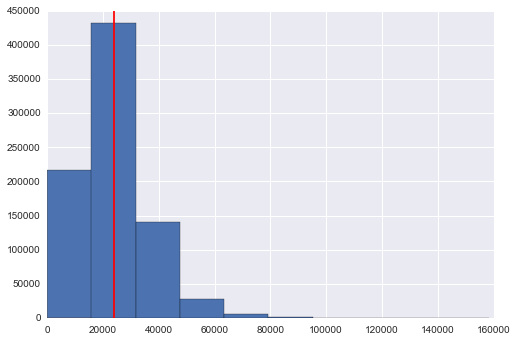

In [6]:
plt.hist(eda_df['damage_taken'])
plt.axvline(np.mean(eda_df['damage_taken']), color='red')

The data frame looks good! We now explore our data.

## Part II: Exploratory Data Analysis (EDA) <a id='EDA'></a>

In [7]:
champions=eda_df['champ'].unique()

### Rank Tier and Region Distribution<a id='tier-region-dist'></a>

We have compiled match data from various rank tiers and regions. Let's check out the distribution of those before we move on.

To give a little context, LoL has a <b>rank tier system.</b> When people play "ranked" games (which is what we specifically downloaded), they play with other people who are of similar playing level. Those who have not played enough ranked games are marked to be in "unranked" tier. Then, goes Bronze, Silver, Gold, Platinum, Diamind, Master, and Challenger in order of increasing skill level. The tier system is based on a percentile. The rank tiers are also broken down into divisions (ex. Bronze III, Platinum I, etc.), but we are not concerned about these subvisions for this project.

This helpful website (http://www.leagueofgraphs.com/rankings/rank-distribution) shows that the distribution of tiers are as follows:

Of those players who are considered "ranked,"  
<b>Bronze</b>: &nbsp;&nbsp;&nbsp; 56.5% of the population  
<b>Silver</b>: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 32.5% of the population  
<b>Gold</b>: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;9.1% of the population  
<b>Platinum</b>: &nbsp;&nbsp;&nbsp;&nbsp;1.6% of the population  
<b>Diamond</b>: &nbsp;&nbsp;&nbsp;&nbsp;0.3% of the population  
<b>Master</b>: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0.01% of the population  
<b>Challenger</b>: 0.0000....1% of the population (this is where professional gamers are)  

To interpret this more simply, Bronze players are in the bottom half in terms of playing abilities and Diamond players are in the top 0.3% percentile.

Let us check whether our pulled data reflects this distribution.

In [8]:
eda_df['region'].unique()

array(['OCE', 'EUNE', 'LAN', 'N-A', 'KR', 'EUW', 'LAS', 'TR', 'BR', 'RU'], dtype=object)

{'EUNE': 7733.0, 'LAN': 4158.0, 'RU': 5183.0, 'OCE': 5091.0, 'TR': 7306.0, 'KR': 14825.0, 'BR': 5198.0, 'N-A': 22172.0, 'EUW': 6295.0, 'LAS': 4402.0}
{'PLATINUM': 10066.0, 'DIAMOND': 2959.0, 'GOLD': 16378.0, 'CHALLENGER': 69.0, 'MASTER': 87.0, 'UNRANKED': 4578.0, 'SILVER': 32739.0, 'BRONZE': 15487.0}


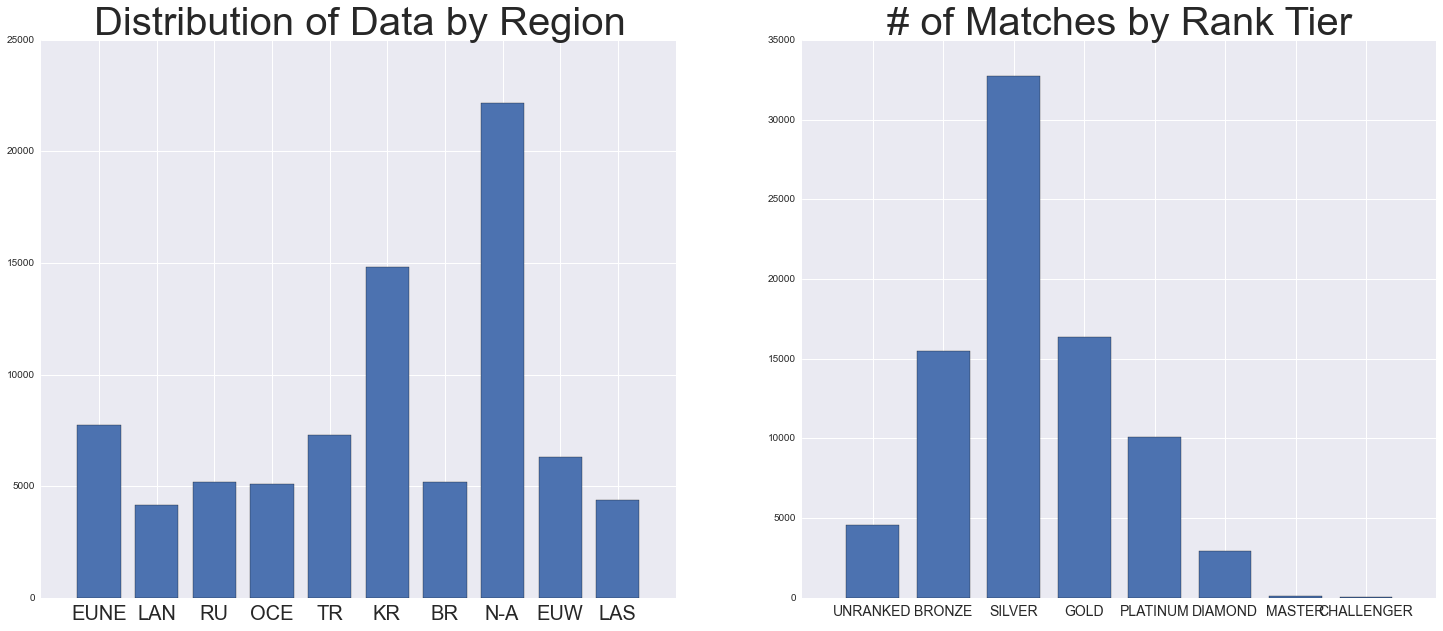

In [9]:
# List of Regions
regions = eda_df['region'].unique()

# Rank Tier Breakdown
region_dist = dict(eda_df['region'].value_counts()/10)
rank_dist = dict(eda_df['match_rank'].value_counts()/10)

print region_dist
print rank_dist

rank_types = ['UNRANKED', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'DIAMOND', 'MASTER', 'CHALLENGER']
rank_values = [4578, 15487, 32739, 16378, 10066, 2959, 87, 69]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10))
ax1.bar(np.arange(len(regions)), region_dist.values(), width=0.75, align='center')
ax1.set_xticks(np.arange(len(regions)))
ax1.set_xticklabels(np.array(region_dist.keys()), size=20)
ax1.set_xlim([-1,10])
ax2.bar(np.arange(len(rank_dist.keys())), rank_values, width=0.75, align='center')
ax2.set_xticks(np.arange(len(rank_dist.keys())))
ax2.set_xticklabels(rank_types, size=14)
ax1.set_title("Distribution of Data by Region", size=40)
ax2.set_title("# of Matches by Rank Tier", size=40)

The bar chart on the left shows the distribution of match data received from each of the 10 regions. Although the data retrieval script tried to run through the matchID's of each region at an equal rate, we do see that we have more data from some regions than others. We have a lot of North American data because we initially started only collecting data from North America. Korean server's API allows 50 requests per 10 seconds rather than 10 per 10 seconds, allowing us to get a lot more data compared to other regions.

The next chart shows the distribution of rank tiers of the games. The distribution appears to be approximately normal with Silver games having both the mean and the median. We do indeed see that there are very few master and challenger tier games.

### Most Popular Champions

There are champion pairs that are very compatible with each other. When a team member chooses one champ, it is natural for the other players (champion selectors) to choose subsequent champs that have synergistic effect with that champ.

For example, in the bottom lane, Vayne and Thresh are an extremely popular pair. Vayne has great burst of attach damage that can melt the enemy champions away. Thresh on the other hand has 3 distinct crowd-control abilities that trap enemies from running away. Once an enemy champion is caught by Thresh's hooks, Vayne can apply virtually unlimited amount of damage.

Here, we try to seek what the most popular champions are. We notice that if we simply looked for the most popular champion pairs, we would likely just receive two champions that are selected the most regardless of their compatibility with each other. So we tried to control for this individual popularity of champions by standardizing them.

In [10]:
#most used champions
appearances = eda_df.groupby('champ')['win'].count()
sorted_appearances=appearances.order(ascending=False)
top_10_champion = sorted_appearances[:10]
bot_10_champion = sorted_appearances[-10:]

print "the most frequently used champions are"
print top_10_champion

print "the least frequently used champions are"
print bot_10_champion

the most frequently used champions are
champ
Vayne          27259
LeeSin         25484
Thresh         22414
Tristana       20234
MissFortune    19215
Blitzcrank     18833
Jinx           17613
Jax            15135
Yasuo          14730
Lucian         14472
Name: win, dtype: int64
the least frequently used champions are
champ
Poppy          1552
Maokai         1545
Cassiopeia     1478
Singed         1331
Skarner        1249
Karthus        1237
Mordekaiser     923
Galio           847
Yorick          712
Urgot           448
Name: win, dtype: int64


The most popular champion in the game is Vayne who was used 27259 times in our data set. The least popular champion is Urgot who was only played 448 times.

For every 61 times Vayne appeared in games, Urgot was played.

In [11]:
#most commonly used pairs

#create a dict with all pair combinations as keys
#iterate through data set and keep a tally of pairs that show up in games


import itertools
d=itertools.combinations(champions, 2)

#creating a dictionary of pair combinations as keys
pairdict={}
for i in d:
    pairdict[i]=0

#create combinations of champion pairs in each team
#iterate through combinations and add 1 to the value in the dictionary
pgroup=eda_df.groupby(['match_ID', 'win'])
test=[]
for g, data in pgroup:
    k=itertools.combinations(data['champ'],2)
    for a,b in k:
        if (a,b) in pairdict:
            pairdict[(a,b)]+=1
        else:
            pairdict[(b,a)]+=1

#control for popularity of champion. Now the values of the dict represent the number of times a given pair appears 
#whenever one or the other champion appears
for (a,b) in pairdict:
    apprcs=appearances[a]+appearances[b]
    test.append(apprcs)
    pairdict[(a,b)]=(2*pairdict[(a,b)])/float(apprcs)

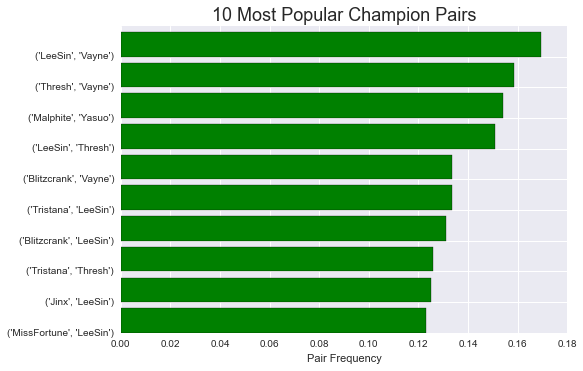

In [12]:
#sort dictionary on values so we can get highest frequency
import operator
sorted_x = sorted(pairdict.items(), key=operator.itemgetter(1))

toptenpairs=sorted_x[-10:]
pairs, count = zip(*sorted_x)
plt.barh(np.arange(10), count[-10:], color='green')
plt.yticks(np.arange(10), pairs[-10:])
plt.xlabel("Pair Frequency")
plt.title("10 Most Popular Champion Pairs", size = 18)

The above chart shows the top 10 most chosen pairs within a team. We must be carefully to note that pair frequency of 0.17 does not mean that we see a ('Lee Sin' and 'Vayne') pair in 17% of teams. The way we defined our function leads to the following interpretation: Given that a team has 'Lee Sin' (or Vayne) on the team, the probability that that team also has 'Vayne' (or Lee Sin) is 17%.  

Even with our attempt to control for individual champion popularity, we see that LeeSin and Vayne take up the highest ranks. But this is because they are just very popular champions in general. One pair that stands out is the ('Malphite', 'Yasuo') combo, unofficially known as the Wombo Combo pair to LoL players.  

Yasuo has an ultimate skill that can only be applied to enemies knocked up in the air, and Malphite has an Area of Effect (AoE) ultimate that can knock up several enemy champions at a time. To look at a quick clip of this process, please check out: https://youtu.be/7DwyrxXYt-g?t=12s

### Win/Loss Rate Based on Champion<a id='win_loss_rate'></a>

Which champions are associated with the highest win rate? How about loss rate?  

Some champions are thought to be significantly and consistently stronger than others in the game. This is why the developers of LoL continues to update the champion's skills and physical stats week after week to maintain game balance. However, it is not always perfect; some champions win more than others, whereas others lose more.  

Let's check out what champion you're most likely to win with and least likely to win with during this pre-season.

In [13]:
champions=eda_df['champ'].unique()
wlrdf=eda_df.groupby(['champ', 'win'])

holder=np.arange(len(champions))
wlrdict=dict(zip(champions, holder))
for k in wlrdict:
    wins=wlrdf.get_group((k, 1))['kills'].count()
    loss=wlrdf.get_group((k, 0))['kills'].count()
    wlrdict[k]=float(wins)/(wins+loss)

Skarner's win rate is 0.56
Nidalee's win rate is 0.42


/Users/jaemincheun/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


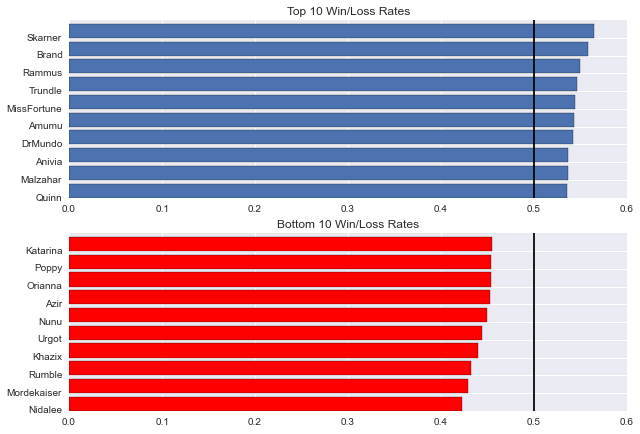

In [15]:
sorted_wlr = sorted(wlrdict.items(), key=operator.itemgetter(1))

plt.figure(figsize=(10,7))
plt.title("Highest and Lowest Win Rate Champs")


bottomtenwlr=sorted_wlr[-10:]
wpairs, wcount = zip(*sorted_wlr)
plt.subplot(211)
plt.barh(np.arange(10), wcount[-10:])
plt.xlim(0.0, 0.6)
plt.vlines(0.5, 0, 10)
plt.yticks(np.arange(10), wpairs[-10:])
plt.title("Top 10 Win/Loss Rates")

toptenwlr=sorted_wlr[:10]
lpairs, lcount = zip(*sorted_wlr)
plt.subplot(212)
plt.barh(np.arange(10), lcount[:10], color='red')
plt.xlim(0.0, 0.6)
plt.vlines(0.5, 0, 10)
plt.yticks(np.arange(10), lpairs[:10])
plt.title("Bottom 10 Win/Loss Rates")

print "Skarner's win rate is %.2f" % wcount[-1]
print "Nidalee's win rate is %.2f" % lcount[:1]

It looks like Skarner is the champion that has the highest win rate. It makes sense given that it received a huge "remake" recently. His skills have improved, and Riot has put in place little portals around the map that increases the movement speed and the attack speed of Skarner.

The bottom chart shows the champions with the lowest win rates. There are different ways to explain the low win rates of each of these champions. For Poppy and Urgot, a remake is very much overdue. Very few people play these champions anymore. Controlling Azir and Oriana take a deep understanding of their skills and a lot of time devoted playing them. These two champions require very precise mechanics and are considered two of the most difficult campions to master.

### KDA by Champion<a id='KDA'></a>

Just as batting average is the long-standing, conventional measure of batting performance, KDA is the widely accepted metric that captures a gamer's performance in eSports analytics. It denotes Kills(K), Deaths(D), and Assists(A) in the game and is calculated as follows:

$$ KDA = \,\frac{(Kills + Assists)}{Deaths} = \,\frac{Kills}{Deaths} + \,\frac{Assists}{Deaths}$$

Just as batting average is considered controversial because it does not accurately capture metric the batting abilities of certain types of batters, KDA has recently met controversy in eSports analytics community. One of the complaints it receives is that it regards Assists (helping a teammate kill an enemy champion) too high. In the conventional KDA calculation, Assists are weighted by the same amount as Kills are. We will see if this complaint is relevant to our data.

In [16]:
cgroup=eda_df.groupby('champ')
champions=eda_df['champ'].unique()
ckills=cgroup['kills'].sum()
cassists=cgroup['assists'].sum()
cdeaths=cgroup['deaths'].sum()
c_kills_mean=cgroup['kills'].mean()
c_deaths_mean=cgroup['deaths'].mean()
c_assists_mean=cgroup['assists'].mean()
kda=(ckills+cassists)/cdeaths
newkda=kda.order(ascending=False)
topten=newkda[:10]
botten=newkda[-10:]
print "The champions with the highest KDA are..."
print np.array(topten.index)
print "The champions with the lowest KDA are..."
print np.array(botten.index)

The champions with the highest KDA are...
['Janna' 'Zac' 'Nami' 'Shen' 'Sejuani' 'Anivia' 'Lux' 'Braum' 'Alistar'
 'Amumu']
The champions with the lowest KDA are...
['Jax' 'Teemo' 'MasterYi' 'XinZhao' 'Heimerdinger' 'Singed' 'Riven' 'Yasuo'
 'Mordekaiser' 'Illaoi']


In [17]:
#given name of champion and list of ranks to compare, plots horizontal bar chart comparing kda
def KDAcomp(name, cranks):
    champlst=[]
    champdct={}
    for i in cranks:
        tgroup=eda_df.groupby(['champ', 'rank']).get_group((name, i))
        kills=tgroup['kills'].sum()
        assists=tgroup['assists'].sum()
        deaths=tgroup['deaths'].sum()
        champlst.append((kills+assists)/float(deaths))
        champdct[i]=(kills+assists)/float(deaths)
    print champlst
    print champdct
    plt.barh(np.arange(len(cranks)), champlst)
    plt.yticks(np.arange(len(cranks)), cranks)
    plt.xlabel(name + " KDA")

[2.016260162601626, 1.4042553191489362, 1.5920490928495197, 1.8968989280245023, 1.6994431185361973]
{'UNRANKED': 1.6994431185361973, 'CHALLENGER': 2.016260162601626, 'DIAMOND': 1.5920490928495197, 'MASTER': 1.4042553191489362, 'BRONZE': 1.8968989280245023}


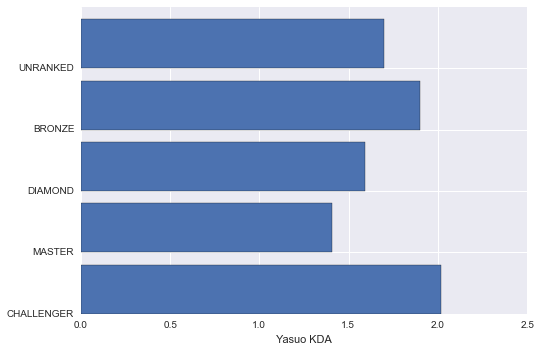

In [18]:
c=['CHALLENGER', 'MASTER', 'DIAMOND', 'BRONZE', 'UNRANKED']
KDAcomp('Yasuo', c)

Yasuo is considered to be the most difficult champion to play. So we thought to see if there is a huge difference between tiers on Yasuo KDA. But it looks like since each tier reflects the player's level. We cannot gauge the difference in KDA as visually as we had hoped.

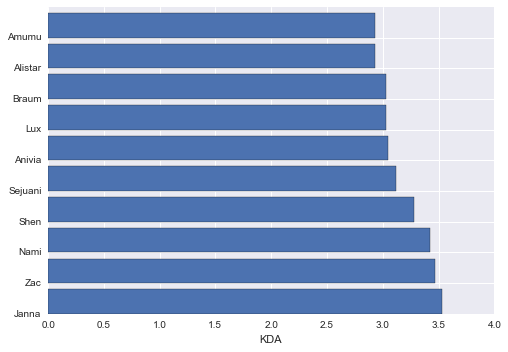

In [19]:
#overall KDA
plt.barh(np.arange(10), topten.values)
plt.yticks(np.arange(10), np.array(topten.index))
plt.xlabel("KDA")

A high KDA requires the following characteristics:  
1) high kills or assists  
2) low deaths

Assists are easier to get than kills. Because only one player can be the one who delivers the finishng blow (a kill), but all you need to receive an assist is to help in the process. If all 5 players on the team gang up on one enemy champion, one person will get a kill and the other four will each receive assists.  

This isw hy we have a lot of "support" champions such as Alistar, Braum, Nami, and Janna on the top KDA list above. Support champions help the dealers (that kill champions) and receive free assists through the game.   

Janna satisfies both the requirements above. She is a support champion who receive a lot of assists without much effort. At the same time, she has very high movement speed, able to avoid enemy champions and ultimately miniminzg her number of deaths.

Shen, Alistar, and Braum are tanky supports that also do not die easily while enjoying easy assists.  

This graph portrays the issue with KDA calculations as mentioned above. Since kills are so much more difficult to get, champions with high assists are the ones with high KDA's.

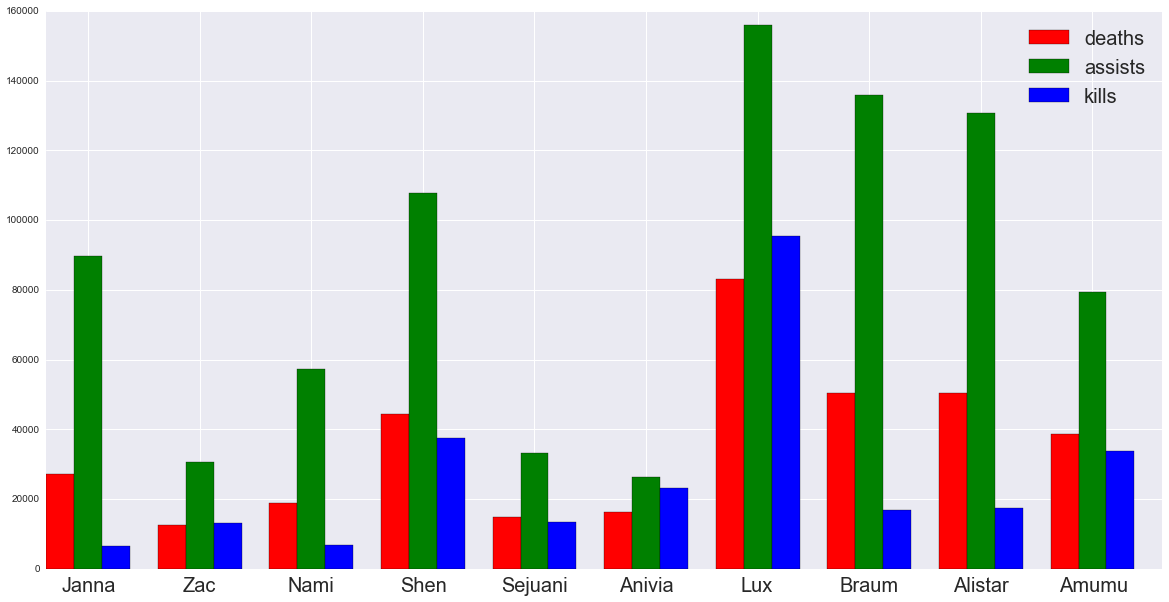

In [20]:
#np.array(deaths)
ttchampions=np.array(topten.index)
dt=[]
at=[]
kt=[]
for i in ttchampions:
    dt.append(cdeaths[i])
    at.append(cassists[i])
    kt.append(ckills[i])

d=np.arange(len(ttchampions))*3
w=0.75
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(d, dt, w, color='red', label='deaths')
ax.bar(d+w, at, w, color='green', label='assists')
ax.bar(d+2*w, kt, w, color='blue', label='kills')
ax.set_xticks(d+3*w/2)
ax.set_xticklabels(ttchampions, size=20)
ax.legend(fontsize=20)

We plot here the kill/assist/kills of the top 10 KDA champions above. As we can see, these champions are highly ranked on the KDA metric because they have very high number of assists.

### Champions by Stat<a id='champion-stat'></a>

We talked about features selection and what each of the features represented. Now before we get into clustering, we will examine if these features bring out the specific characteristics of various champs.

In [21]:
klist=cgroup['kills'].agg(np.mean)
kmax=klist.idxmax()

quantcolumns=['total_heal',
'wards_placed',
'cc_dealt',
'jungle_killed',
'creep_score',
'damage_taken',
'max_crit',
'max_multi_kill',
'gold_earned',
'p_damage_to_champs',
'm_damage_to_champs',
'deaths']
bestchamp={}
for i in quantcolumns:
    holder=cgroup[i].agg(np.mean)
    bestchamp[i]=holder.idxmax()

bestchamp

{'cc_dealt': 'Anivia',
 'creep_score': 'Gangplank',
 'damage_taken': 'Warwick',
 'deaths': 'Akali',
 'gold_earned': 'Gangplank',
 'jungle_killed': 'MasterYi',
 'm_damage_to_champs': 'Karthus',
 'max_crit': 'Caitlyn',
 'max_multi_kill': 'Katarina',
 'p_damage_to_champs': 'Quinn',
 'total_heal': 'Zac',
 'wards_placed': 'Janna'}

Above, we simply listed the champions that correspond to the highest number in each of the quantitative features.  

This list makes a lot of sense. 

<b>Anivia</b> is a champion that constantly deals Area of Effect (AOE) crowd controlling abilities to multiple champions at the time throughout the game.  
<b>Warwick</b>, although a powerful fighter and jungler, usually goes for a tanky build and can withstand a lot of damage.  
<b>Caitlyn</b> has a powerful ultimate skill that qualifies for a critical hit, able to double her regular ultimate damage.  
<b>Zac</b> picks up slobs of goo throughout the game which heals him.   
<b>Janna</b> is an extremely mobile support champion who can roam around the map and place many sight wards throughout the map.

But just listeing them is not enough to see if the features we selected will accurately cluster the champions into the right roles. Now, we plot a distribution of the features. To really visualize how the champions differ in these features, we plot the top 3, middle 3, and bottom 3 for each feature.

In [22]:
#given feature, return top 3, middle 3, and bottom 3 champions of that feature in a dictionary?

def topmiddlebottom(fn):
    c=cgroup[fn].agg(np.mean)
    cn=c.order(ascending=False)
    tmb={}
    tmblist=[]
    tmb['bottom']=np.array(cn[-3:].index)
    tmblist.append(list(cn[-3:].index))
    tmb['middle']=np.array(cn[64:67].index)
    tmblist.append(list(cn[64:67].index))
    tmb['top']=np.array(cn[:3].index)
    tmblist.append(list(cn[:3].index))
    
    #flatten tmblist
    tmblist=[item for sublist in tmblist for item in sublist]
    return tmb, tmblist

In [23]:
#given a champion, a list, and a colormap, it returns the color corresponding to the champion relative to that list
#red means bottom, blue means middle, green means top
colormap=['red', 'blue','green']

def colorfunc(a, lst, cmap=colormap):
    i=lst.index(a)
    if i<=2:
        return cmap[0]
    elif i<=5:
        return cmap[1]
    else:
        return cmap[2]
    

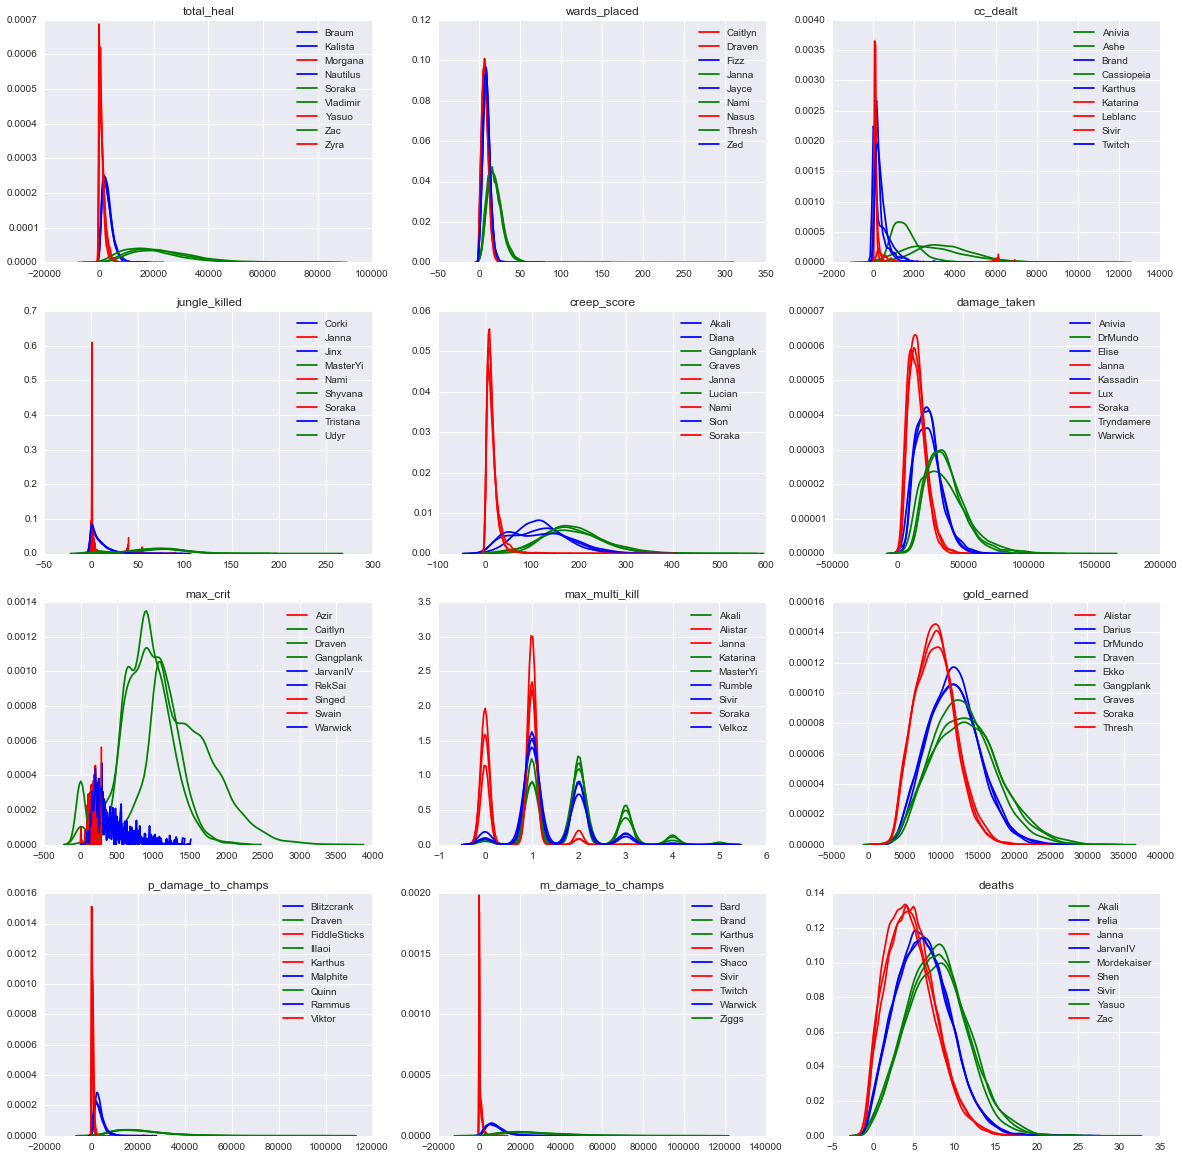

In [24]:
fig, ax = plt.subplots(4,3, figsize=(20,20))
for index, row in enumerate(ax):
    f1name=quantcolumns[index*3]
    f1dict, f1list=topmiddlebottom(f1name)
    f2name=quantcolumns[index*3+1]
    f2dict, f2list=topmiddlebottom(f2name)
    f3name=quantcolumns[index*3+2]
    f3dict, f3list=topmiddlebottom(f3name)
    row[0].set_title(f1name)
    row[1].set_title(f2name)
    row[2].set_title(f3name)
    for g, data in cgroup:
        if g in f1list:
            sns.kdeplot(data[f1name], ax = row[0], label=g, color=colorfunc(g, f1list))
        if g in f2list:
            sns.kdeplot(data[f2name], ax = row[1], label=g, color=colorfunc(g, f2list))
        if g in f3list:
            sns.kdeplot(data[f3name], ax = row[2], label=g, color=colorfunc(g, f3list))   
#red means bottom, blue means middle, green means top

These are some fascinating results!

We have a lot of features here, so we will reserve explaining every single one of them and only mention the most distinguished plots.

Max_multi_kill shows the distribution of champions who are able to thrive in a team fight from killing one enemy champion after another. The top three champions noted here are Akali, Katarina, and Master Yi. Interestingly enough, these are the three champions that have what is called a "kill reset." After using powerful abilities to kill an enemy champion, their cooldowns reset, enabling them to use the same set of skills again. This means that these champions can consistently and frequently use their skills and have the potential to kill as many as all 5 enemy champions if played appropriately. Of course, the trade-off is that they are very fragile to champion attacks.

Damage-taken is another interesting plot. Tanky champions such as Dr. Mundo, Tryndamere, and Warwick can withstand a ton of damage from enemy champions. Their goal is to disrupt the enemy team's main damage dealers while being the focus of the enemy attack. By absorbing the enemies' damage, tankers keep our team's most fragile champions (assassins, supports, ranged attackers) safe. Tryndamere's ultimate skill is actually being invulnerable for 3 seconds, meaning that it can withstand an infinite amount of damage that are being dealt by the enemy team. Dr. Mundo's ultimat skill is regenerating his own health at 5% of his maximum health per second for 12 seconds, making him extremely resilient during team fights.

Seeing how well the features distinguish the innate characteristics and roles of the champions, we are now assured that they can be used for our clustering algorithms below!!!

## PART III: Clustering and Prediction<a id='clustering'></a>

### Standardizing the Data<a id='standardization'></a>

Each LoL game is different in duration and player skill level. We must appropriately standardize each of the quantitative stats by the team. We accomplish this by standardizing on GroupBy groups by match_ID and win.

In [27]:
STANDARDIZABLE = [u'kills', u'assists', u'deaths', u'gold_earned',
       u'p_damage_to_champs', u'm_damage_to_champs', u'damage_taken', u'creep_score',
       u'jungle_killed', u'cc_dealt', u'wards_placed', u'total_heal']
BINARY = [u'max_multi_kill', u'max_crit',u'no_killing_spree']

In [28]:
eda_df.tail(10)

,region,match_ID,participant,rank,match_rank,champ,win,kills,assists,deaths,...,m_damage_to_champs,max_multi_kill,max_crit,damage_taken,no_killing_spree,creep_score,jungle_killed,cc_dealt,wards_placed,total_heal
823620,TR,332063081,1,SILVER,SILVER,Veigar,0,4,7,8,...,9590,1,0,17593,1,119,0,139,6,1313
823621,TR,332063081,2,UNRANKED,SILVER,Nidalee,0,3,8,13,...,13077,2,827,33314,1,122,1,51,3,8539
823622,TR,332063081,3,SILVER,SILVER,Tryndamere,0,10,6,10,...,1990,1,773,55279,2,197,25,206,10,11629
823623,TR,332063081,4,SILVER,SILVER,Gragas,0,9,5,9,...,22150,3,498,58790,2,141,48,1174,12,23609
823624,TR,332063081,5,BRONZE,SILVER,Taric,0,1,16,10,...,6302,1,0,36687,0,44,0,1457,8,14506
823625,TR,332063081,6,SILVER,SILVER,Lucian,1,8,10,4,...,4640,1,518,18244,1,222,14,0,4,2444
823626,TR,332063081,7,BRONZE,SILVER,Thresh,1,4,14,5,...,8634,1,0,18682,1,15,0,458,15,1304
823627,TR,332063081,8,SILVER,SILVER,Illaoi,1,3,7,9,...,1211,1,0,34832,0,150,1,205,7,6904
823628,TR,332063081,9,BRONZE,SILVER,Shaco,1,28,4,5,...,18224,2,1364,30891,4,108,86,1239,13,6214
823629,TR,332063081,10,BRONZE,SILVER,Lux,1,7,16,4,...,27129,1,0,14492,2,106,6,161,5,1226


In [29]:
normalized=eda_df.copy()
normalized.head(20)

,region,match_ID,participant,rank,match_rank,champ,win,kills,assists,deaths,...,m_damage_to_champs,max_multi_kill,max_crit,damage_taken,no_killing_spree,creep_score,jungle_killed,cc_dealt,wards_placed,total_heal
0,OCE,113859173,1,SILVER,SILVER,MissFortune,0,10,10,7,...,2542,2,878,25178,3,253,18,506,5,4450
1,OCE,113859173,2,SILVER,SILVER,Vladimir,0,12,7,9,...,35581,1,0,47495,4,268,1,667,12,32996
2,OCE,113859173,3,UNRANKED,SILVER,Morgana,0,0,9,7,...,5745,0,0,14913,0,40,0,968,16,140
3,OCE,113859173,4,UNRANKED,SILVER,Akali,0,12,9,13,...,17557,2,0,39497,2,81,0,975,6,598
4,OCE,113859173,5,GOLD,SILVER,XinZhao,0,5,10,12,...,6175,1,173,44762,0,53,52,1852,15,11141
5,OCE,113859173,6,SILVER,SILVER,Tristana,1,9,10,6,...,4333,2,681,24242,2,234,11,144,6,5231
6,OCE,113859173,7,UNRANKED,SILVER,Blitzcrank,1,5,15,7,...,5739,1,0,31238,1,20,1,112,18,5104
7,OCE,113859173,8,SILVER,SILVER,Riven,1,9,10,13,...,0,2,0,32805,1,172,12,237,7,436
8,OCE,113859173,9,GOLD,SILVER,Talon,1,15,8,10,...,243,2,0,35775,3,193,16,877,14,2683
9,OCE,113859173,10,GOLD,SILVER,Nunu,1,10,18,3,...,25176,2,0,54151,3,62,95,2535,17,22512


In [30]:
%%time
normalized[STANDARDIZABLE] = normalized.groupby(['match_ID', 'region', 'win']).transform(lambda x: (x/x.sum() if x.sum() != 0 else 0))[STANDARDIZABLE]

CPU times: user 9min 34s, sys: 6.11 s, total: 9min 40s
Wall time: 9min 41s


In [31]:
print normalized.isnull().values.any()
print pd.isnull(normalized).any(1).nonzero()[0]

False
[]


In [32]:
%%time
normalized[BINARY] = normalized.groupby(['match_ID', 'region', 'win']).transform(lambda x: (x == x.max()))[BINARY]

CPU times: user 4min 41s, sys: 3.39 s, total: 4min 44s
Wall time: 4min 46s


In [33]:
clusteringdf=normalized.ix[:, 'kills':]
length=(clusteringdf.shape[0])
clusteringdf['max_multi_kill']=clusteringdf['max_multi_kill']+pd.Series([0]*length)
clusteringdf['max_crit']=clusteringdf['max_crit']+pd.Series([0]*length)
clusteringdf['no_killing_spree']=clusteringdf['no_killing_spree']+pd.Series([0]*length)


clusteringdf.head()


,kills,assists,deaths,gold_earned,p_damage_to_champs,m_damage_to_champs,max_multi_kill,max_crit,damage_taken,no_killing_spree,creep_score,jungle_killed,cc_dealt,wards_placed,total_heal
0,0.256410,0.222222,0.145833,0.243140,0.658047,0.037604,1,1,0.146516,0,0.364029,0.253521,0.101852,0.092593,0.090218
1,0.307692,0.155556,0.187500,0.244591,0.029887,0.526346,0,0,0.276383,1,0.385612,0.014085,0.134259,0.222222,0.668951
2,0.000000,0.200000,0.145833,0.148516,0.010623,0.084985,0,0,0.086782,0,0.057554,0.000000,0.194847,0.296296,0.002838
3,0.307692,0.200000,0.270833,0.183806,0.078024,0.259719,1,0,0.229841,0,0.116547,0.000000,0.196256,0.111111,0.012124
4,0.128205,0.222222,0.250000,0.179948,0.223418,0.091346,0,0,0.260479,0,0.076259,0.732394,0.372786,0.277778,0.225869


##PCA <a id='pca'></a>

/Users/jaemincheun/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


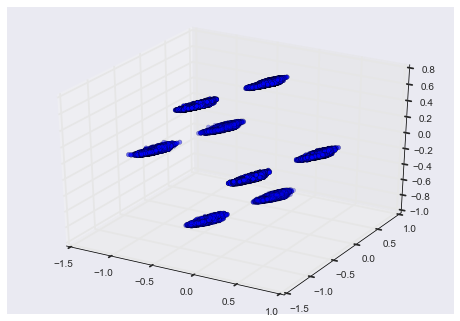

In [34]:
# Normalization shrinks all values to some distribution around a mean of 0. 

from sklearn.decomposition import PCA
pca=PCA(n_components=3)
pca.fit(clusteringdf)
dnew=pca.transform(clusteringdf)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

first=[i[0] for i in dnew]
second=[i[1] for i in dnew]
third=[i[2] for i in dnew]

ax.scatter(first, second, third)

We run PCA on our data and reduce the number of dimensions to three for the purpose of visualization. We see that our data form 8 clusters, which may indicate that our unreduced data also has clusters. We hope that the gridsearch process below for finding the optimal number of clusters for knn will return a similar result. Please see below for more discussion on these clusters. 

### Prediction Methods<a id='prediction-methods'></a>

As we stated, the general idea behind our predictions is to predict the outcome of a match when the only given information is the composition of both teams. We determine team composition by looking at each player and designating them as falling into a certain player category. These player categories will be obtained by using our clustering algorithms below, which we expect to reflect to some degree the visualization produced by our PCA above. 

The cluster a player falls into says something about his overall play style. For example, some players prefer to play roles that involve staying behind their teammates, providing support, and healing. Such players will likely have low numbers in the damage_dealt features but high in TotalHealAmount. Since there are six official roles that players may fall into (Assassin, Fighter, Mage, Marksmen, Support, Tank), which to a large degree dictate their play styles, we expect our clusters to reflect them. For example, we expect to see a cluster who's members typically play ADC. We will be able to easily check this by looking at the centroids for the different clusters. 

The visualization from our PCA indicates that our data may exhibit more than six clusters. We hypothesize that this may be the case because even with our six acknowledged roles, players may have different play styles within those roles. For example, some Assassin-style players may prefer to play in more of a tankish role than the typical assassin. 

The baseline model against which we will compare all of our predictions is a 50-50 model, where each team has a 50% chance of winning.

###Splitting Training and Testing Data<a id='splitting-training-and-testing-data'></a>

We first split our data into train and test data. Instead of using train_test_split used in our homeworks to randomly sample rows from the dataset, we have to sample by matches. We set the size of our training data set to be 0.9.

In [35]:
length=(normalized.shape[0])
normalized['max_multi_kill']=normalized['max_multi_kill']+pd.Series([0]*length)
normalized['max_crit']=normalized['max_crit']+pd.Series([0]*length)
normalized['no_killing_spree']=normalized['no_killing_spree']+pd.Series([0]*length)

In [36]:
############################################################################
# Split data into test and train 
# : because we have to sample by matches, we cannot use train_test_split. 
############################################################################
import random
import copy

train_size = 0.9

num_matches = len(normalized)/10
num_training = int(num_matches * train_size)

training_index = random.sample(xrange(num_matches), num_training)
training_index = [x * 10 for x in training_index]

merged_index = copy.copy(training_index)

for i in xrange(1,10):
    merged_index += [x+i for x in training_index]

train_data = normalized[normalized.index.isin(merged_index)]
test_data = normalized[~normalized.index.isin(merged_index)]

y=normalized['win']
X=normalized.ix[:, 'kills':]

ytrain=train_data['win']
Xtrain=train_data.ix[:, 'kills':]
ytest=test_data['win']
Xtest=test_data.ix[:, 'kills':]

## K-Means<a id='k-means'></a>


We first use the K-Means Method to cluster the data. Given a set of observations, k-means clustering partitions the data into $k$ sets $S = \{S_1, \cdots , S_k\} to minimize the within-cluster sum of squares. We want to mnimize the function:

$\sum_{i=1}^{k} \sum_{x \in S_i} || x - \mu_i ||^2$

where $x$ is an observation and $\mu_i$ is the $i^{th}$ cluster centroid.

In [79]:
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.vq import kmeans, vq
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans

In [66]:
%%time

knn=KMeans()

clf_kmeans=GridSearchCV(knn, param_grid={'n_clusters': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}, scoring='accuracy', cv=10)

clf_kemans.fit(Xtrain,ytrain)

CPU times: user 2h 11min 13s, sys: 6min 30s, total: 2h 17min 44s
Wall time: 35min 43s


To select the number of clusters $k$, we run a 10-fold cross validation over $k$ to find a local optimizer. We see that the optimal number of clusters is 8 for our case.

In [69]:
k = clf_kmeans.get_params()['estimator__n_clusters']
k

8

We then annotate on our data set which cluster each row belongs to.

In [38]:
centroids,_ = kmeans(Xtrain,k)
idx,_ = vq(Xtrain,centroids)
train_data["KMeansClusterID"] = idx
idx,_ = vq(Xtest,centroids)
test_data["KMeansClusterID"] = idx

/Users/jaemincheun/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jaemincheun/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Also for future reference, we save the information about our centroids on a seperate csv file, centroids.csv.

In [39]:
centroids

array([[  2.05897130e-01,   1.92287668e-01,   1.94784400e-01,
          2.00726827e-01,   1.72832835e-01,   2.30600965e-01,
          1.00000000e+00,   0.00000000e+00,   2.04381788e-01,
          0.00000000e+00,   1.97230732e-01,   2.29712405e-01,
          2.16522103e-01,   1.95664081e-01,   2.06907066e-01],
       [  1.09979468e-01,   2.38791952e-01,   1.97459164e-01,
          1.80631011e-01,   1.14899502e-01,   2.24016251e-01,
          0.00000000e+00,   0.00000000e+00,   1.85033240e-01,
          0.00000000e+00,   1.70203473e-01,   4.21830788e-02,
          1.60065920e-01,   2.33814917e-01,   1.64903790e-01],
       [  2.31478118e-01,   1.70383869e-01,   1.94546876e-01,
          2.16214092e-01,   3.59919858e-01,   9.35923827e-02,
          1.00000000e+00,   1.00000000e+00,   1.86296978e-01,
          0.00000000e+00,   2.86283383e-01,   1.66649866e-01,
          1.59114763e-01,   1.66430180e-01,   1.70867321e-01],
       [  3.38404858e-01,   1.56594287e-01,   2.06938349e-01,
     

In [42]:
def arraytodict(array):
    returndict={}
    length=len(array)
    for i in range(length):
        returndict['c'+str(i+1)]=array[i]
    return returndict

In [44]:
centroid_dict = arraytodict(centroids)

In [45]:
import csv
d = centroid_dict
with open("centroid.csv", "wb") as outfile:
   writer = csv.writer(outfile)
   writer.writerow(d.keys())
   writer.writerows(zip(*d.values()))

In [46]:
train_data

,region,match_ID,participant,rank,match_rank,champ,win,kills,assists,deaths,...,max_multi_kill,max_crit,damage_taken,no_killing_spree,creep_score,jungle_killed,cc_dealt,wards_placed,total_heal,KMeansClusterID
0,OCE,113859173,1,SILVER,SILVER,MissFortune,0,0.256410,0.222222,0.145833,...,1,1,0.146516,0,0.364029,0.253521,0.101852,0.092593,0.090218,2
1,OCE,113859173,2,SILVER,SILVER,Vladimir,0,0.307692,0.155556,0.187500,...,0,0,0.276383,1,0.385612,0.014085,0.134259,0.222222,0.668951,7
2,OCE,113859173,3,UNRANKED,SILVER,Morgana,0,0.000000,0.200000,0.145833,...,0,0,0.086782,0,0.057554,0.000000,0.194847,0.296296,0.002838,1
3,OCE,113859173,4,UNRANKED,SILVER,Akali,0,0.307692,0.200000,0.270833,...,1,0,0.229841,0,0.116547,0.000000,0.196256,0.111111,0.012124,0
4,OCE,113859173,5,GOLD,SILVER,XinZhao,0,0.128205,0.222222,0.250000,...,0,0,0.260479,0,0.076259,0.732394,0.372786,0.277778,0.225869,6
5,OCE,113859173,6,SILVER,SILVER,Tristana,1,0.187500,0.163934,0.153846,...,1,1,0.136030,0,0.343612,0.081481,0.036876,0.096774,0.145443,2
6,OCE,113859173,7,UNRANKED,SILVER,Blitzcrank,1,0.104167,0.245902,0.179487,...,0,0,0.175287,0,0.029369,0.007407,0.028681,0.290323,0.141912,1
7,OCE,113859173,8,SILVER,SILVER,Riven,1,0.187500,0.163934,0.333333,...,1,0,0.184080,0,0.252570,0.088889,0.060691,0.112903,0.012123,0
8,OCE,113859173,9,GOLD,SILVER,Talon,1,0.312500,0.131148,0.256410,...,1,0,0.200745,1,0.283407,0.118519,0.224584,0.225806,0.074598,5
9,OCE,113859173,10,GOLD,SILVER,Nunu,1,0.208333,0.295082,0.076923,...,1,0,0.303859,1,0.091043,0.703704,0.649168,0.274194,0.625924,5


### DP Means<a id='dp-means'></a>

Even though k-means is straightforward to implement and works for a variety of applications, there are some drawbacks to the approach because it assumes that the variance of the distribution of each variable is spherical and each cluster has roughly equal number of observations. In this section, we see how Bayesian model can offer flexibility for clustering applications. For example, Bayesian nonparametrics can be used for modeling infinite mixtures, and hierachical Bayesian model can be used to model shared clusters across multiple data sets.
We explore the DP-means, which is a nonparametric expectation-maximization (EM) algorithm derived using a Dirichlet process (DP) mixture of Gaussian model. 

In short, the DP-means is different from the K-means in that it includes a penalty for the number of cluster, and thus the user do not have to specify the number of clusters beforehand. Tje different is that a new cluster is formed whenever an observation is sufficiently far away from all existing cluster centroid, with some user-defined threashold. Suppose that the generative model for the EM algorithm was a DP mixture of Gaussians model with covarance equal to $\sigma I$. Letting $\sigma \Rightarrow 0$ for the DP mixture model yields the objective function: 

$\sum_{i=1}^{k} \sum_{x \in S_i} || x - \mu_i ||^2 + (k-1)\lambda^2$

where $S = \{S_1, \cdots , S_k \}$ is the set of clusters, $x$ is an observation, and $\mu_i$ is the $i^{th}$ cluster centroid. Note that unlike in k-means, $k$ is now a variable to be optimized over.

In [161]:
def dp_means(data, Lambda, max_iters=10, tolerance=10e-3):
    features = data.columns.values[1:]
    n_obs = len(data)
    # initially 1 cluster
    k = 1
    
    # assignments : cluster labels for each point
    data["Assignments"] = 1
    mu = []
    temp = dict()
    for col in features:
        temp[col] = data[col].mean()
    mu.append(temp)
    is_converged = False
    n_iters = 0
    ss_old = float('inf')
    ss_new = float('inf')
    while n_iters < max_iters:
        n_iters += 1
        for i in range(n_obs):
            distances = np.repeat(None, k)
            for j in range(k):
                distances[j] = sum((data.iloc[i][col] - mu[j][col]) ** 2 for col in features)
            if (min(distances) > Lambda):
                k += 1
                data["Assignments"][i] = k
                temp = dict()
                for col in features:
                    temp[col] = data.iloc[i][col]
                mu.append(temp)
            else:
                data.Assignments[i] = np.argmin(distances) + 1
        for j in range(k):
            if (len(data[data.Assignments == j])  > 0):
                temp = dict()
                for feature in features:
                    temp[feature] = data[data.Assignments == j][feature].mean()
                mu[j] = temp
        ss_new = 0      
        for i in range(n_obs):
            for j in range(k):
                ss_new  = ss_new + sum((data.iloc[i][col] - mu[j][col]) ** 2 for col in features)
        ss_change = ss_old - ss_new
        is_converged = ss_change < tolerance
        ss_old = ss_new
    
    return {'centers':mu,
            'assignments': data.Assignments,
            'k': k , 'n_iters': n_iters}

In [ ]:
dp_means(Xtrain, Lambda = 2.5)

##Feature Selection (again!)<a id='feature-selection-again'></a>

In order to predict match outcomes using this feature we must create a new dataframe. The rows of this dataframe will be the matches played while there will be $m*2+1$ features, where $m$ is the number of clusters returned by our clustering algorithms, and we have 1 additional feature that records the win result. The first $m$ features represent the team composition of Team 1. 

Let's say that our clustering algorithms returned 8 clusters as the ideal number of clusters. Since there are 8 clusters, that also means that there are 8 possible categories into which a player can be assigned when determining the composition of a team. For example, let's say for a given game Team 1 has 2 players who belong to cluster 1, 1 player who belongs to cluster 3, and 2 players who belong class 5. Let's say Team 2 has 1 player in cluster 1 and 4 players in cluster 4. Then Feature 1 will have a value of 2, which represents the fact that Team 1 has 2 members who belong to cluster 1. Feature 3 will equal 1 and Feature 5 will equal 2 as well which represent the fact that Team 1 has 1 member in cluster 3 and 2 members in cluster 5. Feature 9 will have a value of 1 which represents the fact that Team 2 has 1 member in cluster 1, and feature 12 will have a value of 4 which represents the fact that Team 2 has 4 members in cluster 4. 

We will use this dataframe as the input for SVM and logistic regression below. 

In [131]:
def new_frame(data, k): 
    matches = len(data)/10
    X1 = np.zeros((matches, k))
    X2 = np.zeros((matches, k))
    # get rid of duplicates
    i = 0 
    match_IDs = list(set(data["match_ID"].values))
    for match in xrange(matches):
        temp = data[data.match_ID == match_IDs[match]]
        temp_win_team = temp[temp.win == 1]
        temp_lost_team = temp[temp.win == 0]
        for cluster in xrange(k):
            X1[match][cluster] = sum(temp_win_team["KMeansClusterID"].values == cluster)
            X2[match][cluster] = sum(temp_lost_team["KMeansClusterID"].values == cluster)
    df = pd.DataFrame()
    df["win"] = np.ones(matches)
    for cluster in xrange(k):
        df["Team1Cluster" + str(cluster)] = X1[:,cluster]
        df["Team2Cluster" + str(cluster)] = X2[:,cluster]
    df_temp = df.copy()
    df_temp["win"] = np.zeros(matches)
    for cluster in xrange(k):
        df_temp["temp"] = df_temp["Team1Cluster" + str(cluster)]
        df_temp["Team1Cluster" + str(cluster)] = df_temp["Team2Cluster" + str(cluster)]
        df_temp["Team2Cluster" + str(cluster)] = df_temp["temp"]
        del df_temp["temp"]
    frames = [df, df_temp]
    new_data = pd.concat(frames)
    return new_data 

In [85]:
from sklearn.linear_model import LogisticRegression

new_train_data = new_frame(train_data, k)
new_test_data = new_frame(test_data, k)

ytrain=new_train_data['win']
Xtrain=new_train_data.ix[:, 1:]

ytest_with_features=new_test_data['win']
Xtest_with_features=new_test_data.ix[:, 1:]

[[ 0.  0.  0. ...,  0.  2.  0.]
 [ 1.  1.  0. ...,  0.  0.  1.]
 [ 0.  1.  0. ...,  0.  1.  0.]
 ..., 
 [ 0.  0.  1. ...,  0.  1.  1.]
 [ 1.  1.  1. ...,  0.  0.  1.]
 [ 1.  0.  0. ...,  1.  0.  0.]]
[[ 0.  2.  0. ...,  1.  0.  1.]
 [ 0.  3.  0. ...,  0.  1.  0.]
 [ 0.  3.  0. ...,  0.  1.  0.]
 ..., 
 [ 2.  1.  1. ...,  1.  0.  0.]
 [ 0.  2.  1. ...,  1.  1.  0.]
 [ 0.  3.  0. ...,  0.  1.  0.]]


In [90]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print "BEST PARAMS", gs.best_params_
    best = gs.best_estimator_
    return best

In [91]:
clf_log=LogisticRegression(penalty="l1")
parameters = {"C": [0.01, 0.1, 1, 10, 100]}
clf_log = cv_optimize(clf_log, parameters, Xtrain, ytrain)
clf_log=clf_log.fit(Xtrain, ytrain)

BEST PARAMS {'C': 0.01}


In [92]:
training_accuracy = clf_log.score(Xtrain, ytrain)
test_accuracy = clf_log.score(Xtest_with_features, ytest_with_features)
print "Using Logistic Regression:"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

Using Logistic Regression:
Accuracy on training data: 0.60
Accuracy on test data:     0.49


In [95]:
from sklearn.svm import LinearSVC

clf_svm=LinearSVC()
parameters = {"C": [0.01, 0.1, 1, 10, 100]}
clf_svm = cv_optimize(clf_svm, parameters, Xtrain, ytrain)
clf_svm=clf_svm.fit(Xtrain, ytrain)

BEST PARAMS {'C': 0.01}


In [96]:
training_accuracy = clf_svm.score(Xtrain, ytrain)
test_accuracy = clf_svm.score(Xtest_with_features, ytest_with_features)
print "Using SVM:"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

Using SVM:
Accuracy on training data: 0.59
Accuracy on test data:     0.50


##Test Data with Champions Only<a id='test-data-with-champions-only'></a>

We have predicting the win/loss of a game given the teams composition, which is based on multiple statistics. However,  we want to ultimately predict win/loss just by looking at champion compostions of the two teams. We first get rid of all the features in the test data except for the which champion each player is playing.

In [48]:
ytest=test_data['win']
Xtest=test_data.loc[:,['match_ID','champ']]

#we create a dictionary where key is the name of the champion, 
#and the value is a list of length #clusters with probabilites of the champion being assigned to that cluster

/Users/jaemincheun/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


We then create a dictionary where the key is a champion, and the value is an array of probability of the champion being assigned to a particular cluster. 

In [49]:
#create dictionary
champ_cluster = dict()
champions = list(set(train_data["champ"].values))
for champion in champions:
    distribution = []
    temp = train_data[train_data.champ == champion]
    for cluster in range(k):
        distribution.append(float(sum(temp["KMeansClusterID"].values == cluster))/len(temp))
    champ_cluster[champion] = distribution        

Now for the each champion in the test data, we assign a clusterID via Monte Carlo Sampling based on the probability matrix we have created. Please do not run the code below, as it will take around three hours to run.

In [51]:
Xtest["KMeansClusterID"] = np.zeros(len(Xtest))
for index in Xtest.index:    
    Xtest["KMeansClusterID"][index] = np.random.choice(k, 1, p=champ_cluster[Xtest["champ"][index]])[0]
Xtest

/Users/jaemincheun/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,match_ID,champ,KMeansClusterID
40,113859243,Alistar,4
41,113859243,Jinx,7
42,113859243,Darius,7
43,113859243,Lux,4
44,113859243,Olaf,4
45,113859243,Jax,4
46,113859243,Draven,5
47,113859243,Malphite,7
48,113859243,Lulu,4
49,113859243,Velkoz,4


We then modify the test data into a new frame we have introduced above.

In [ ]:
Xtest["win"] = ytest
Xtest
new_test_champ_data = new_frame(Xtest, k)
ytest_champ=new_test_champ_data['win']
Xtest_champ=new_test_champ_data.ix[:, 1:]

In [ ]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(penalty="l1")
parameters = {"C": [0.01, 0.1, 1, 10, 100]}
clf = cv_optimize(clf, parameters, Xtrain, ytrain)
clf=clf.fit(Xtrain, ytrain)
training_accuracy = clf.score(Xtrain, ytrain)

In [97]:
test_accuracy = clf_log.score(Xtest_champ, ytest_champ)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

Accuracy on test data:     0.51


In [98]:
test_accuracy = clf_svm.score(Xtest_champ, ytest_champ)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

Accuracy on test data:     0.51


In [99]:
clf_log.predict_proba(Xtest_champ)

array([[ 0.66482254,  0.33517746],
       [ 0.5588926 ,  0.4411074 ],
       [ 0.50000303,  0.49999697],
       ..., 
       [ 0.47657482,  0.52342518],
       [ 0.56759362,  0.43240638],
       [ 0.36009671,  0.63990329]])

As we can see, our predictive models do not perform any better than our baseline model of 50-50. We believe this is the case for two reasons.

First, our algorithms were run on data from all matches of all ranks (Gold, Silver, Bronze, etc.). In different levels we expect champion use to matter very differently. For example, in lower levels when players are not able to use champions very well and likely will not play roles (tank, assassin, etc.) very well either. The outcome of such a game will have substantially more randomness than one in which the players know very well how to use their champions and play their roles perfectly. Since all of these players are considered together, it is not surprising that there is substantial randomness in our data with respect to the predictive ability of team composition. 

Second, the outcome of a game can be affected by so many different things that it is almost expected for a model solely based on team composition to have very little predictive ability. For example, whether or not the players are communicating while playing together or whether they are using a particular strategy that they are bringing to a game are two of many other decisions and/or circumstances that may affect the outcome of a game. This is especially the case because in many games we expect players to do their best when it comes to playing a balanced game and not intentionally mess up team composition. 

## Part IV: Prediction of win/loss <a id='prediction-of-win/loss'></a>

Now using the model we have created above, given two team compositions, we can successfully predict which team has a higher probability of winning. Note that this prediction only takes the team composition in consideration. 

In [145]:
def predict_wins(team1, team2):
    champions = team1 + team2
    test_df = pd.DataFrame()
    test_df["champ"] = champions
    test_df["match_ID"] = 1
    test_df["win"] = [1,1,1,1,1,0,0,0,0,0]
    test_df["KMeansClusterID"] = np.zeros(10)
    win = []
    for i in xrange(50):
        for index in test_df.index:    
            test_df["KMeansClusterID"][index] = np.random.choice(k, 1, p=champ_cluster[test_df["champ"][index]])[0]
        new_test_champ_data = new_frame(test_df, k)                 
        ytest_champ=new_test_champ_data['win']
        Xtest_champ=new_test_champ_data.ix[:, 1:]
        win.append(clf_log.predict_proba(Xtest_champ)[0][0])
    print "Probability Team 1 will win against Team 2 is: %0.2f" % (sum(win) / float(len(win)))

###Scenario 1: Five Supports vs. Balanced Team<a id='scenario1'></a>

We imagine a situation where team1 consists of 5 support characters, where team2 has a solid composition with each champion belonging to different role outlined by Riot. Because team1 has a very unbalanced composition, it is very unlikely for them to win against team2.

In [ ]:
team1 = ["Janna", "Nami", "Soraka", "Taric", "Bard"]
team2 = ["Malphite", "LeeSin", "Jinx", "Yasuo", "Nami"]
predict_wins(team1, team2)

Our model predicts that the probability of team1 winning against team2 is 32%, which is coherent with our initial guess. This tells us given this composition, if the player is on team1, even though giving up before game has a small penalty, because the odds of winning are very small, he should concede the game before the battle phase begins. 

###Scenario 2: Balanced Team vs. Five Tanks<a id='scenario2'></a>

Now we imagine a situation where team1 is balanced and team2 has 5 tanks. Because team2 has a very unbalanced composition, it is very unlikely for them to win against team1.

In [157]:
team1 = ["Malphite", "LeeSin", "Jinx", "Yasuo", "Nami"]
team2 = ["Malphite", "Shen", "Singed", "Rammus", "Nasus"]
predict_wins(team1, team2)

Probability Team 1 will win against Team 2 is: 0.58


/Users/jaemincheun/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Our model predicts that the probability of team1 winning against team2 is 58%, which is again coherent with our guess. 

###Scenario 3: Balanced Team vs. Balanced Team<a id='scenario3'></a>

This time, both teams are reasonably balanced. 

In [156]:
team1 = ["Heimerdinger", "Leblanc", "Annie", "Sivir", "Sejuani"]
team2 = ["Malphite", "LeeSin", "Jinx", "Yasuo", "Nami"]
predict_wins(team1, team2)

Probability Team 1 will win against Team 2 is: 0.48


/Users/jaemincheun/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Our model predicts that the probability of team1 winning against team2 is 48%, which means that both teams have very good compositions, and thus it is hard to predict which team will win. 

While our predictive model on the test data in general was essentially the same as our baseline, we do see some indication here that our model is accurate in some ways. In Situation 1, when the team composition is such that odds are heavily leaning towards Team 2's victory we see that the model predicts with much greater certainty (62%) that Team 2 will indeed win. In Situation 2 when we give it a scenario that makes it clearly more likely that Team 1 will win we see that the model predicts it will win with (58%). Finally, when we give the model balanced teams it predicts the probability of winning as approximately 50%.

# Part V: Conclusion <a id='conclusion'></a>

The objective of our project was to use team composition to inform a prediction on the outcome of a match. Our first step was to obtain data on actual gameplay through the League of Legends API. Next, we explored the data deriving some interesting tidbits of information on things like KDA's and most popular champions. Then we proceeded to define exactly how we would go about describing team composition. We ran clustering algorithms on our data and created a new feature in our data that assigned observations to clusters. Our belief was that clusters reflected popular play styles in the game. Finally, we used only our new data on team composition to try and predict the outcomes of games. 

Our results indicated that our approach has low predictive ability. On the test set both logistic regression and SVM only predicted the correct game result 51% percent of the time, which is hardly different from our baseline prediction model of 50-50. However, this result is not altogether surprising for the reasons mentioned above. Moreover, it reflected the obvious fact that lower ranked players are less capable in playing the different player roles. 

In addition, our model reflected expected outcomes when given simulated matches with heavily unbalanced teams, and therefore may still be a valid reflection of the real world. We saw our approach give us correct predictions with greater certainty when team composition was very clearly in favor of one side's victory, and less certain predictions when team compositions were such that the outcome would heavily depend on other factors.

To conclude, in the majority of cases our model has weak predictive ability. However, this may just reflect the fact that match outcomes depend on so much more than team composition. Moreover, our model still reflected expected outcomes when given specific team compositions that made match outcomes more clear, which indicates that our approach of predicting on team composition worked to an extent, and could be improve on in future endeavors. 

###Future Directions

Although the temporal and logistic challenges posed by data collection made us unable to pursue this with our current project, we would like to run our algorithms on rank specific data in the future. We expect that if we only use data from the highest ranked matches, our predictions will be noticeably stronger. 
